In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

DATASET_FOLDER = Path('./mnist')
class_labels = ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [2]:
# Function for one-hot encoding
def one_hot_encoding(label_data):
    row_number = label_data.shape[0]
    num_labels = 10  # MNIST dataset (0-9)
    encoded_labels = np.zeros((row_number, num_labels), dtype='int')
    encoded_labels[list(range(row_number)), label_data] = 1
    return encoded_labels

# Function to read pixel data from the dataset
def read_pixels(data_path):
    with open(data_path, 'rb') as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    flattened_pixels = pixel_data.reshape(-1, 784)
    normalized_pixels = flattened_pixels / 255
    return normalized_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with open(data_path, 'rb') as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

# Function to read the entire dataset
def read_dataset(path):
    X_train = read_pixels(path/"train-images-idx3-ubyte")
    y_train = read_labels(path/"train-labels-idx1-ubyte")
    X_test = read_pixels(path/"t10k-images-idx3-ubyte")
    y_test = read_labels(path/"t10k-labels-idx1-ubyte")
    return X_train, y_train, X_test, y_test

def split_val(X_train, y_train):
    return X_train[10000:], y_train[10000:], X_train[:10000], y_train[:10000]

def z(X, W):
    W0 = W[:,0]
    W = W[:,1:]
    return W0 + X @ W.T

def softmax(Z):
    # Z -= np.max(Z, axis=1, keepdims=True)
    expZ = np.exp(Z)
    return expZ / expZ.sum(axis=1, keepdims=True)

def predict(X, W):
    Z = z(X, W)
    return softmax(Z)

def predict_class(X, W):
    return np.argmax(predict(X,W), axis=-1)

def cross_entropy_loss(Y, T):
    return -(np.log(Y) * T).sum() / T.shape[0]

def regularization_loss(W, l2):
    return l2 / 2 * np.linalg.norm(W[:,1:], 2)

def calculate_loss(Y, T, W, l2):
    ce_loss = cross_entropy_loss(Y, T)
    l2_loss = regularization_loss(W, l2)
    return ce_loss + l2_loss

def grad(X, Y, T, W, l2):
    X = np.hstack((np.ones(shape=(X.shape[0],1)), X))
    L_derivative = Y - T
    l2_grad = l2 * W
    return L_derivative.T @ X + l2_grad

def new_weights(X, Y, T, W, lr, l2):
    return W - lr * grad(X, Y, T, W, l2)

def confusion_matrix(labels, predictions, size):
    cm = np.zeros((size,size)).astype(np.int32)
    for i in range(len(labels)):
        cm[labels[i]][predictions[i]] += 1
    return cm

def calculate_precision_recall(cm):
    num_classes = cm.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)

    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp

        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0

    return precision, recall

def f_beta_score(precision, recall, beta=1.0):
    beta_squared = beta ** 2
    f_beta = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall)
    return f_beta

In [3]:
X_train, y_train, X_test, y_test = read_dataset(DATASET_FOLDER)
X_train, y_train, X_val, y_val = split_val(X_train, y_train)
label_train, label_val, label_test = [np.argmax(_, axis=-1) for _ in [y_train, y_val, y_test]]
print(*[_.shape for _ in [X_train, y_train, X_val, y_val, X_test, y_test]])

(50000, 784) (50000, 10) (10000, 784) (10000, 10) (10000, 784) (10000, 10)


In [ ]:
batch_size = 200
weights = np.random.normal(0,1,(10,785))
lr = 5 * (10 ** (-4))
l2 = 10 ** (-4)
epochs = 100

In [4]:
def train_model(batch_size, weights, lr, l2, epochs=100):
    val_accs = []
    _, val_acc = validate(weights, X_val, y_val, label_val)
    # val_accs.append(val_acc)
    print(f"Initial acc: {val_acc*100:.2f}")
    for epoch in range(epochs):
        weights, loss = train_epoch(batch_size, weights, lr, l2)
        _, val_acc = validate(weights, X_val, y_val, label_val)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs}, loss = {loss:.6f}, val_acc = {val_acc*100:.2f}")
    return weights, val_accs

def train_epoch(batch_size, weights, lr, l2):
    batch_count = int(X_train.shape[0] / batch_size)
    loss = 0
    for batch in range(batch_count):
        X = X_train[batch*batch_size:(batch+1)*batch_size]
        T = y_train[batch*batch_size:(batch+1)*batch_size]
        Y = predict(X, weights)
        loss += calculate_loss(Y, T, weights, l2)
        weights = new_weights(X, Y, T, weights, lr, l2)
    loss /= batch_count
    return weights, loss

def validate(weights, X, y, label):
    prediction_val = predict_class(X_val, weights)
    val_cm=confusion_matrix(label_val, prediction_val, y_val.shape[1])
    val_acc=val_cm.trace()/val_cm.sum()
    return val_cm, val_acc

In [ ]:
default_batch_size = 200
default_weight_init = np.random.normal(0, 1, (10, 785))
default_lr = 5e-4
default_l2 = 1e-4

batch_sizes = [1,64,3000]
weight_inits = {
    'zeros':np.zeros((10,785)), 
    'uniform':np.random.uniform(-1,1,(10,785)), 
    'normal':np.random.normal(0,1,(10,785))
}
lrs = [10**i for i in [-2,-3,-4,-5]] 
l2s = [10**i for i in [-2,-4,-9]] 

In [ ]:
def draw_comparison_graph(results, legend_label, title, xlabel, ylabel, save_path):
    plt.figure(figsize=(10, 6))
    for alt, accuracies in results.items():
        plt.plot(range(1, len(accuracies)+1), accuracies, label=f'{legend_label}: {alt}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

In [ ]:
batch_size_results = {}
for batch_size in batch_sizes:
    _, batch_size_results[batch_size] = train_model(
        batch_size, default_weight_init, default_lr, default_l2
    )
draw_comparison_graph(batch_size_results, 'Batch Size', 'Performance Comparison: Batch Sizes', 'Epochs', 'Accuracy', 'batch_size_comparison.png')

In [ ]:
weight_init_results = {}
for weight_init in weight_inits:
    _, weight_init_results[weight_init] = train_model(
        default_batch_size, weight_inits[weight_init], default_lr, default_l2
    )
    

draw_comparison_graph(weight_init_results, 'Weight initialization', 'Performance Comparison: Weight Initialization', 'Epochs', 'Accuracy', 'weight_init_comparison.png')

In [ ]:
lr_results = {}
for lr in lrs:
    _, lr_results[lr] = train_model(
        default_batch_size, default_weight_init, lr, default_l2
    )
draw_comparison_graph(lr_results, 'Learning rate', 'Performance Comparison: Learning Rate', 'Epochs', 'Accuracy', 'lr_comparison.png')

In [ ]:
l2_results = {}
for l2 in l2s:
    _, l2_results[l2] = train_model(
        default_batch_size, default_weight_init, default_lr, l2
    )
draw_comparison_graph(lr_results, 'Regularization coefficient', 'Performance Comparison: Regularization Coefficient', 'Epochs', 'Accuracy', 'l2_comparison.png')

In [ ]:
best_batch_size = batch_sizes[0]
best_weight_init = weight_inits['zeros']
best_lr = lrs[1]
best_l2 = lrs[1]

best_weights, best_result = train_model(
    best_batch_size, best_weight_init, best_lr, best_l2
)
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(best_result)), best_result)
plt.title('Performance of Model with Best Hyperparameters')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('best_performance.png')
plt.show()

In [31]:
prediction_test = predict_class(X_test, best_weights)
cm=confusion_matrix(label_test, prediction_test, y_test.shape[1])
acc=cm.trace()/cm.sum()
acc

0.8399

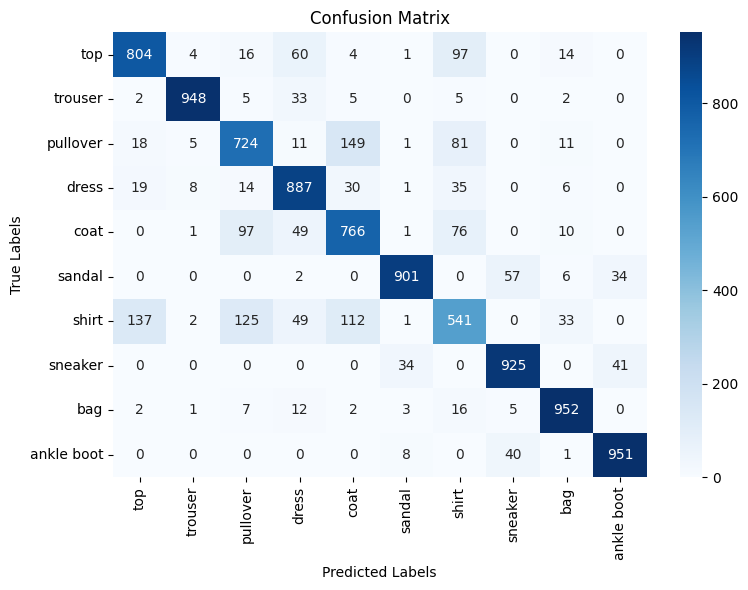

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

title='Confusion Matrix'
cmap='Blues'
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
            xticklabels=class_labels, yticklabels=class_labels)

plt.title(title)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.savefig('confusion_matrix_best.png')
plt.show()

In [ ]:
for index, weight in enumerate(best_weights):
    weight = weight[1:].reshape(28,28)
    plt.matshow(weight, cmap=plt.cm.gray, vmin=0.5*weight.min(), vmax=0.5*weight.max())
    plt.savefig(f"weight_{index}.png")

In [5]:
best_weights = np.load('best.npy')

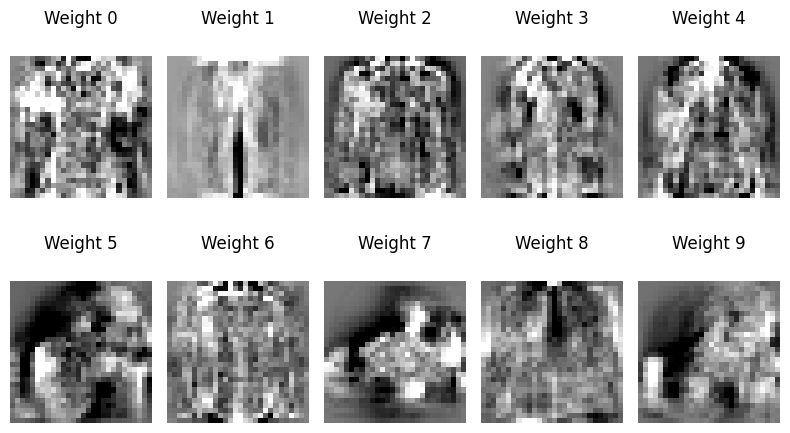

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(8,5))  # 2 rows, 5 columns

for i, ax in enumerate(axes.flat):
    ax.matshow(best_weights[i,1:].reshape(28,28), cmap=plt.cm.gray, vmin=0.5*best_weights[i,1:].min(), vmax=0.5*best_weights[i,1:].max())
    ax.axis('off')  # Turn off axis labels
    ax.set_title(f"Weight {i}")

plt.tight_layout()
plt.savefig("weights.png")
plt.show()

In [39]:
precision, recall = calculate_precision_recall(cm)
ef1 = f_beta_score(precision, recall, 1)
ef2 = f_beta_score(precision, recall, 2)

for index,(p,r,f1,f2) in enumerate(zip(precision, recall, ef1, ef2)):
    print(f"{index} - {class_labels[index]} & {p*100:.2f}\% & {r*100:.2f}\% & {f1:.2f} & {f2:.2f} \\\\")

0 - top & 81.87\% & 80.40\% & 0.81 & 0.81 \\
1 - trouser & 97.83\% & 94.80\% & 0.96 & 0.95 \\
2 - pullover & 73.28\% & 72.40\% & 0.73 & 0.73 \\
3 - dress & 80.42\% & 88.70\% & 0.84 & 0.87 \\
4 - coat & 71.72\% & 76.60\% & 0.74 & 0.76 \\
5 - sandal & 94.74\% & 90.10\% & 0.92 & 0.91 \\
6 - shirt & 63.57\% & 54.10\% & 0.58 & 0.56 \\
7 - sneaker & 90.07\% & 92.50\% & 0.91 & 0.92 \\
8 - bag & 91.98\% & 95.20\% & 0.94 & 0.95 \\
9 - ankle boot & 92.69\% & 95.10\% & 0.94 & 0.95 \\
